Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
tf.__version__

'2.15.0'

In [8]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [9]:
# import dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip"

Archive:  /content/gdrive/MyDrive/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating

In [10]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [11]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [12]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [13]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split= 0.2,
  subset= 'training',
  image_size=(img_height,img_width),
  batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [14]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split= 0.2,
  subset= 'validation',
  image_size=(img_height,img_width),
  batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [15]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

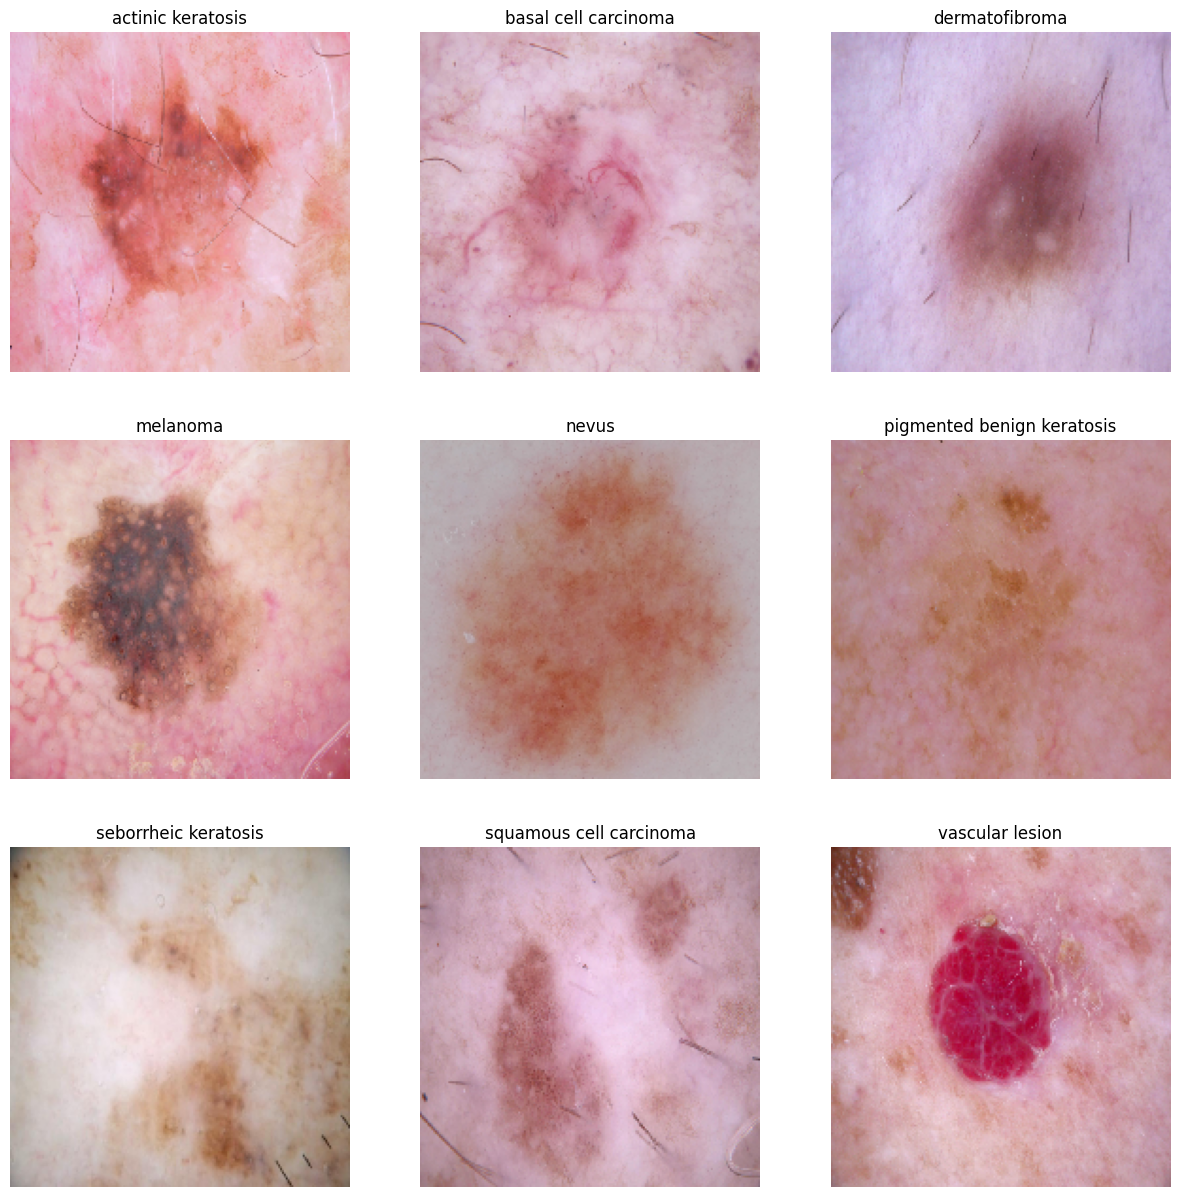

In [17]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

### your code goes here, you can use training or validation data to visualize
files_path_dict = {}
for c in class_names:
  files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

plt.figure(figsize=(15,15))
index = 0
for c in class_names:
  path_list = files_path_dict[c][:1]
  index += 1
  plt.subplot(3,3,index)
  plt.imshow(load_img(path_list[0],target_size=(180,180)))
  plt.title(c)
  plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [19]:
### Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [26]:
from tensorflow.keras.optimizers import RMSprop
### Todo, choose an appropirate optimiser and loss function
# Adam is mostly being used as faster convergence than SGD
model.compile(optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [27]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                   

### Train the model

In [28]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 7s 93ms/step - loss: 1.5498 - accuracy: 0.4542 - val_loss: 1.4543 - val_accuracy: 0.4922
Epoch 2/20
56/56 [==============================] - 5s 89ms/step - loss: 1.4426 - accuracy: 0.4955 - val_loss: 1.4588 - val_accuracy: 0.5213
Epoch 3/20
56/56 [==============================] - 5s 88ms/step - loss: 1.4030 - accuracy: 0.5006 - val_loss: 1.4370 - val_accuracy: 0.5168
Epoch 4/20
56/56 [==============================] - 5s 89ms/step - loss: 1.3554 - accuracy: 0.5061 - val_loss: 1.4025 - val_accuracy: 0.5123
Epoch 5/20
56/56 [==============================] - 5s 88ms/step - loss: 1.2928 - accuracy: 0.5312 - val_loss: 1.4697 - val_accuracy: 0.5034
Epoch 6/20
56/56 [==============================] - 5s 89ms/step - loss: 1.2636 - accuracy: 0.5564 - val_loss: 1.4180 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 5s 90ms/step - loss: 1.1868 - accuracy: 0.5759 - val_loss: 1.5218 - val_accuracy: 0.5078
Epoch 8/20
56/56 [======

### Visualizing training results

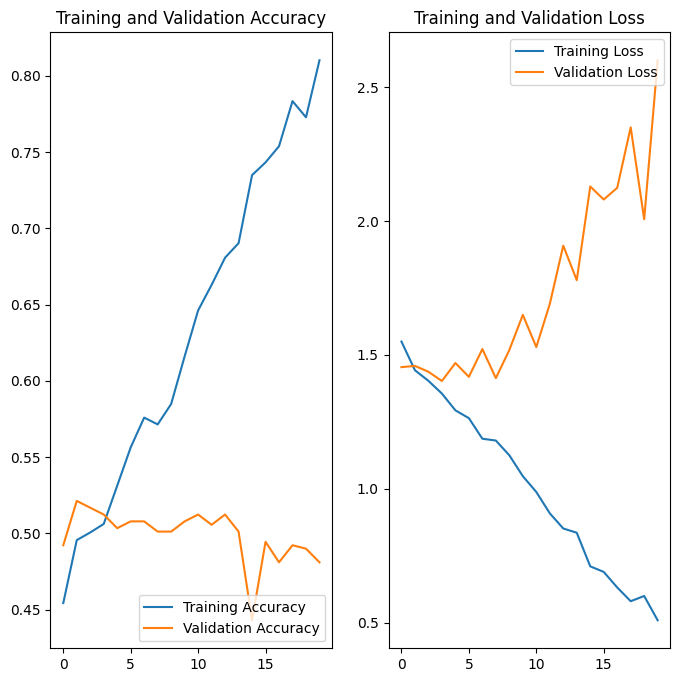

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


14/14 [==============================] - 0s 20ms/step - loss: 1.3837 - accuracy: 0.5190
Accuracy:  0.5200892686843872
Validation Accuracy:  0.5190156698226929
Loss:  1.3230209350585938
Validation Loss 1.3837366104125977


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [30]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_aug = keras.Sequential([
  layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
  layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

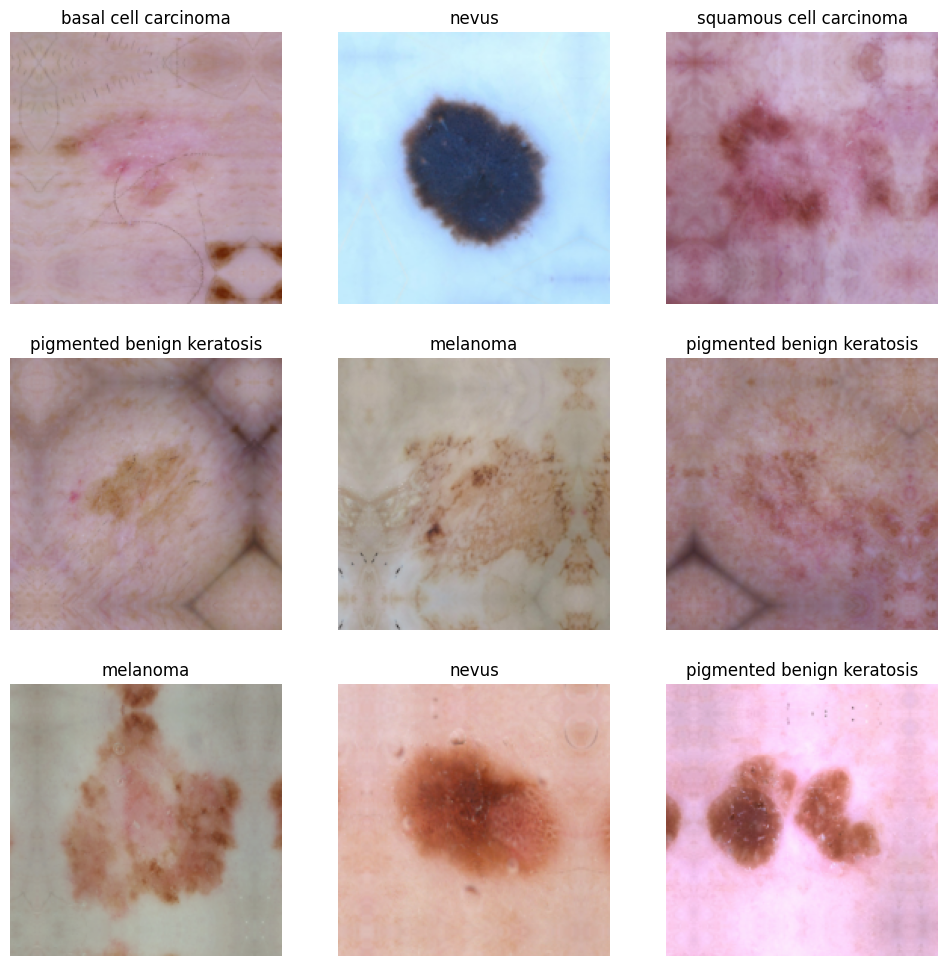

In [31]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data_aug(images)[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [32]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

num_classes = 9
model = Sequential([ data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compiling the model

In [33]:
## Your code goes here
model.compile(optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

### Training the model

In [34]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 97ms/step - loss: 2.0562 - accuracy: 0.1869 - val_loss: 1.9401 - val_accuracy: 0.2953
Epoch 2/20
56/56 [==============================] - 5s 91ms/step - loss: 2.0735 - accuracy: 0.2143 - val_loss: 1.9219 - val_accuracy: 0.3132
Epoch 3/20
56/56 [==============================] - 5s 91ms/step - loss: 1.8985 - accuracy: 0.2924 - val_loss: 1.8886 - val_accuracy: 0.2975
Epoch 4/20
56/56 [==============================] - 5s 90ms/step - loss: 1.8401 - accuracy: 0.3170 - val_loss: 1.7155 - val_accuracy: 0.3557
Epoch 5/20
56/56 [==============================] - 5s 89ms/step - loss: 1.8100 - accuracy: 0.3320 - val_loss: 1.8876 - val_accuracy: 0.2975
Epoch 6/20
56/56 [==============================] - 5s 90ms/step - loss: 1.7571 - accuracy: 0.3532 - val_loss: 1.6884 - val_accuracy: 0.3893
Epoch 7/20
56/56 [==============================] - 5s 89ms/step - loss: 1.6434 - accuracy: 0.3906 - val_loss: 1.5919 - val_accuracy: 0.4116
Epoch 8/20
56

### Visualizing the results

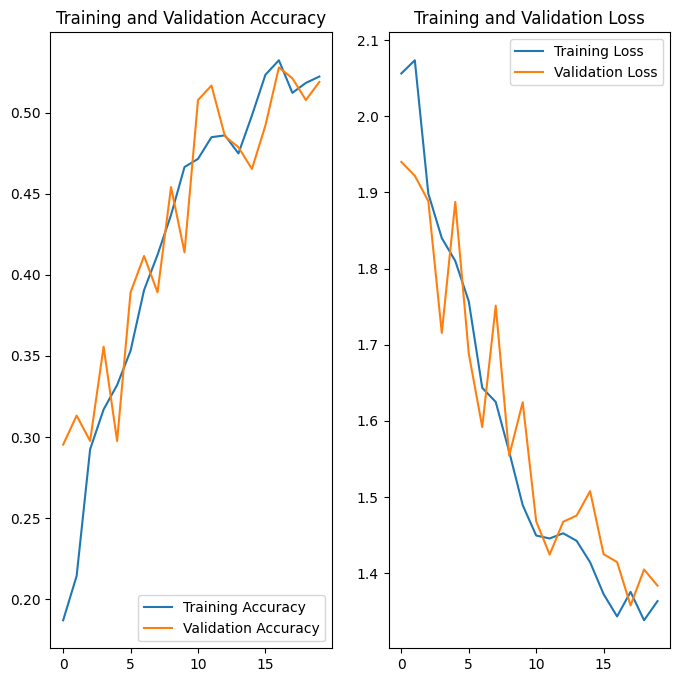

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 21ms/step - loss: 1.3837 - accuracy: 0.5190
Accuracy:  0.5200892686843872
Validation Accuracy:  0.5190156698226929
Loss:  1.3230208158493042
Validation Loss 1.3837366104125977


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- There's the overfit due to data augmentation

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [38]:
## Your code goes here.
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,actinic keratosis
1,/content/Skin cancer ISIC The International Sk...,actinic keratosis
2,/content/Skin cancer ISIC The International Sk...,actinic keratosis
3,/content/Skin cancer ISIC The International Sk...,actinic keratosis
4,/content/Skin cancer ISIC The International Sk...,actinic keratosis
...,...,...
2234,/content/Skin cancer ISIC The International Sk...,vascular lesion
2235,/content/Skin cancer ISIC The International Sk...,vascular lesion
2236,/content/Skin cancer ISIC The International Sk...,vascular lesion
2237,/content/Skin cancer ISIC The International Sk...,vascular lesion


No charts were generated by quickchart


<BarContainer object of 9 artists>

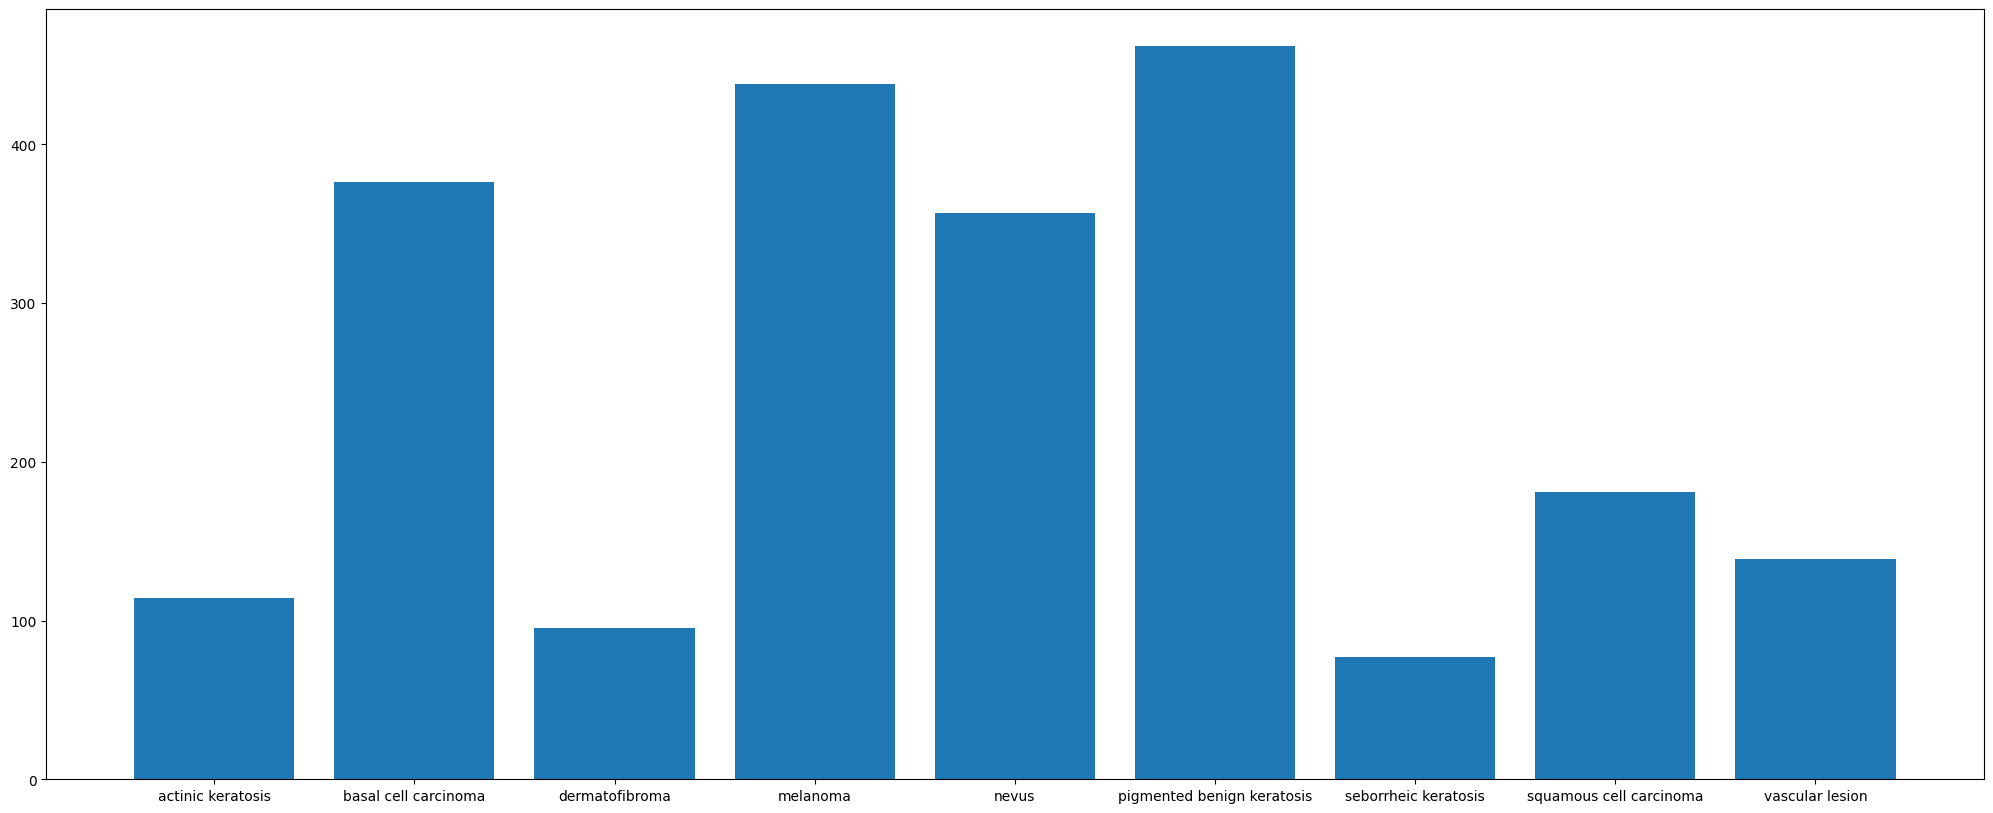

In [39]:
# prompt: Using dataframe original_df:

# No task provided. Please provide a specific task to perform on the original_df dataframe.
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples? => Seborrheic Keratosis
#### - Which classes dominate the data in terms proportionate number of samples? => Pigmented Benign Keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [41]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [42]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6D308EA2F0>: 100%|██████████| 500/500 [00:17<00:00, 28.48 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6DB4E366E0>: 100%|██████████| 500/500 [00:21<00:00, 23.60 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6DB4BF91B0>: 100%|██████████| 500/500 [00:17<00:00, 28.52 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6D30E34D00>: 100%|██████████| 500/500 [01:21<00:00,  6.12 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F6D308EA2F0>: 100%|██████████| 500/500 [01:12<00:00,  6.86 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6DB30A5840>: 100%|██████████| 500/500 [00:18<00:00, 27.62 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6DB4EE39D0>: 100%|██████████| 500/500 [00:36<00:00, 13.82 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6D900C41C0>: 100%|██████████| 500/500 [00:14<00:00, 34.62 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6DB30A79D0>: 100%|██████████| 500/500 [00:15<00:00, 32.19 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [43]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [45]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0024948.jpg_94f04e43-fc69-43fa-bd54-1eb6ec68c12d.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027615.jpg_db5d31f7-2252-48d1-8bfe-186506950c4e.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0024646.jpg_05f7ff9a-3780-416a-a277-a83dccd6067c.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000481.jpg_eec7e6a9-a5c7-4bcc-857e-2f6a90d795a9.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000468.jpg_8ed52204-df1d-4e61-bccc-bd4c9665a060.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000237.jpg_b951cf48-168e-48d2-a255-1875ae0b213b.jpg'

In [46]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [48]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [49]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-49-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [50]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [51]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [53]:
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [54]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [58]:
input_shape = (180,180,3)
model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(keras.layers.BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(keras.layers.BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 90, 90, 32)        128       
 Normalization)                                                  
                                                                 
 dropout_2 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 64)       

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [60]:
model.compile(optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


#### **Todo:**  Train your model

In [61]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 43s 198ms/step - loss: nan - accuracy: 0.0924 - val_loss: nan - val_accuracy: 0.0898
Epoch 2/30
169/169 [==============================] - 30s 173ms/step - loss: nan - accuracy: 0.0914 - val_loss: nan - val_accuracy: 0.0898
Epoch 3/30
169/169 [==============================] - 29s 170ms/step - loss: nan - accuracy: 0.0914 - val_loss: nan - val_accuracy: 0.0898
Epoch 4/30
169/169 [==============================] - 37s 212ms/step - loss: nan - accuracy: 0.0914 - val_loss: nan - val_accuracy: 0.0898
Epoch 5/30
169/169 [==============================] - 30s 173ms/step - loss: nan - accuracy: 0.0914 - val_loss: nan - val_accuracy: 0.0898
Epoch 6/30
169/169 [==============================] - 31s 174ms/step - loss: nan - accuracy: 0.0914 - val_loss: nan - val_accuracy: 0.0898
Epoch 7/30
169/169 [==============================] - 29s 169ms/step - loss: nan - accuracy: 0.0914 - val_loss: nan - val_accuracy: 0.0898
Epoch 8/30
169/169 [==================

#### **Todo:**  Visualize the model results

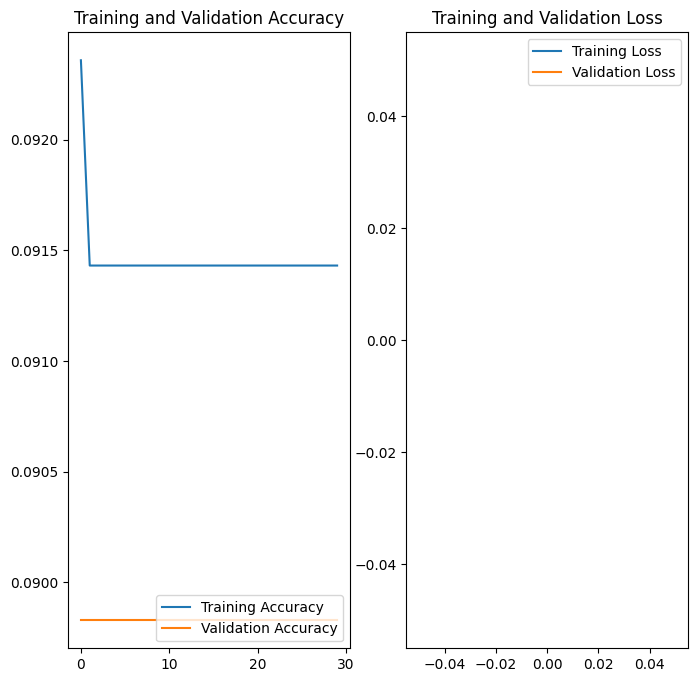

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [63]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 5s 90ms/step - loss: nan - accuracy: 0.0898
Accuracy:  0.09143175184726715
Validation Accuracy:  0.08982925117015839
Loss:  nan
Validation Loss nan


In [ ]:
0